# Perovskite search space

In this example using SMACT we search the compositional space of possible perovskite (ABX$_3$) structures. The space is limited by chemical and crystallographic criteria.

* We search only for materials with O, S, Se, F, Cl, Br, or I as the X site.
* We search only for materials with a B site which is known to have octahedral coordination, taken from the [data of Shannon.](http://scripts.iucr.org/cgi-bin/paper?a12967)
* We classify the potential structures of the resultant charge neutral combinations based on the ratios of the Shannon radii and the [Goldschmidt tolerance factor.](http://link.springer.com/article/10.1007%2FBF01507527)

In [2]:
import smact.lattice 

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib
%matplotlib inline
import smact
from os import path
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools 

label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.color_cycle'] = ['#0C8080','#D66C14', '#1762B0']

## Setting up the perovskite lattice
SMACT lattice is an object which contains information about the positions of the lattice sites, the oxiation states of the potential species at those sites and the spacegroup of the lattice. It can be used to quickly build atomistic models of the results of a screening.

In [4]:
site_A = smact.lattice.Site([0,0,0],[+1,+2,+3])
site_B = smact.lattice.Site([0.5,0.5,0.5],[+5,+4,+3,+2])
site_C = smact.lattice.Site([0.5,0.5,0.5],[-2,-1])
perovskite = smact.lattice.Lattice([site_A,site_B,site_C],space_group=221)

## Set up the chemical space for the search
Initially we search through the first 100 elements blindly. The total number of possible combinations is returned.

In [5]:
search = smact.ordered_elements(1,103)
initial_total = len(list(itertools.combinations(search, 3)))

## Applying chemical restrictions
We now narrow the search space by applying some chemical criteria. 
1. The X site is either O, S, Se, Cl, Br, or I.
2. The B site is known to have octahedral coordination from the [data of Shannon.](http://scripts.iucr.org/cgi-bin/paper?a12967)

In [6]:
A_list = []
B_list = []
C_list = [['O',-2,1.35],['S',-2,1.84],['Se',-2,1.98],['F',-1,1.29],['Cl',-1,1.81],['Br',-1,1.96],['I',-1,2.2]]
for element in search:
    with open(path.join(smact.data_directory, 'shannon_radii.csv'), 'rU') as f:
        reader = csv.reader(f)
        r_shannon=False
        for row in reader:
            if row[0]==element and int(row[1]) in site_A.oxidation_states:
                A_list.append([row[0], float(row[1]), float(row[4])])
            if row[2]=="6_n" and row[0]==element and int(row[1]) in site_B.oxidation_states:
                B_list.append([row[0], float(row[1]), float(row[4])])

## Iterative search
Having constructed potential element lists for each of the sites we now do an iterative search through all poaaible combinations, applying different levels of screening.
1. A =/= B.
2. Charge neutrality.
3. Goldschmidt tolerance factors.
4. Environmental screening (greater HHI resource than CZTS).

In [7]:
elements_dict = {}
for symbol, _, __ in A_list + B_list + C_list:
    if symbol not in elements_dict:
        elements_dict.update({symbol: smact.Element(symbol)})

In [8]:
B_el = elements_dict['B']
B_el.HHI_R

2000.0

In [13]:
charge_balanced = []
goldschmidt_cubic = []
goldschmidt_ortho = []
a_too_large = []
A_B_similar = []
pauling_perov = []
anion_stats = []
hhi_cdte = 2904
enviro_perovskites = 0
total = 0
for C_sym, C_ox, C_r in C_list:
    C_el = elements_dict[C_sym]
    anion_hex = 0
    anion_cub = 0
    anion_ort = 0
    anion_env = 0
    for B_sym, B_ox, B_r in B_list:
        B_el = elements_dict[B_sym]
        for A_sym, A_ox, A_r in A_list:
            A_el = elements_dict[A_sym]
            # Require different element on each site
            if B_sym != A_sym:        
                if C_sym != A_sym and C_sym != B_sym:
                    total = total + 1
                    if A_ox + B_ox + 3*C_ox == 0:
                         charge_balanced.append([A_el, B_el, C_el])
                         if A_el.HHI_R and B_el.HHI_R and C_el.HHI_R:
                             hhi_material = (A_el.HHI_R * A_el.mass + 
                                             B_el.HHI_R * B_el.mass +
                                             3*C_el.HHI_R *C_el.mass) / (A_el.mass + B_el.mass + 3*C_el.mass)               
                         else:
                            hhi_material = 10000 # Set high value to eliminate combination
                         
                         tol = (A_r + C_r)/(np.sqrt(2)*(B_r + C_r))
                         if tol > 1.0:
                            a_too_large.append([A_el,B_el,C_el])
                            anion_hex = anion_hex+1
                            if hhi_material < hhi_cdte:
                                enviro_perovskites = enviro_perovskites + 1
                                anion_env = anion_env + 1
                         elif 0.9 < tol <= 1.0:
                            goldschmidt_cubic.append([A_el, B_el, C_el])
                            anion_cub = anion_cub + 1
                            if hhi_material < hhi_cdte:
                                enviro_perovskites = enviro_perovskites + 1
                                anion_env = anion_env + 1
                         elif 0.71 <= tol <= 0.9:
                            if hhi_material < hhi_cdte:
                                enviro_perovskites = enviro_perovskites + 1
                                anion_env = anion_env + 1
                            goldschmidt_ortho.append([A_el, B_el, C_el])
                            anion_ort = anion_ort + 1
                        else:
                            A_B_similar.append([A_el, B_el, C_el])
    anion_stats.append([anion_hex,anion_cub,anion_ort,anion_env]) 

In [14]:
print anion_stats[0]
print anion_stats[1]
print anion_stats[2]

[1142, 1461, 6137, 4172]
[528, 1160, 6873, 4187]
[416, 1089, 7046, 4268]


In [15]:
number_of_perovskites = 0
for i in 0, 1, 2, 3, 4, 5:
    for j in 1, 2:
        number_of_perovskites = anion_stats[i][j] + number_of_perovskites
        
number_hex = 0
for i in 0, 1, 2, 3, 4, 5:
    number_hex = number_hex + anion_stats[i][0]
    
number_cubic = 0
for i in 0, 1, 2, 3, 4, 5:
    number_cubic = number_cubic + anion_stats[i][1]
    
number_ortho = 0
for i in 0, 1, 2, 3, 4, 5:
    number_ortho = number_ortho + anion_stats[i][2]

## Look at the results

In [16]:
print "Total number before any screening: \t\t\t\t{0:8d}".format(initial_total)
print "Total number after initial selection of chemical criteria:\t{0:8d}".format(len(list(itertools.product(A_list,B_list,C_list))))
print "Total number after charge neutrality:\t\t\t\t{0:8d}".format(len(charge_balanced))
#print "Total number after electronegativity criterion applied: ", len(pauling_perov)
print "Total number after Goldschmidt allowed combinations:\t\t{0:8d}".format(number_of_perovskites)
print "Total number after environmental factors:\t\t\t{0:8d}".format(enviro_perovskites)

Total number before any screening: 				  176851
Total number after initial selection of chemical criteria:	  288204
Total number after charge neutrality:				   41725
Total number after Goldschmidt allowed combinations:		   26567
Total number after environmental factors:			   13415


## Structure

Plot pie charts of the percentages of different structure types based on anion. There is a clear trend towards decreasing percentage of hexagonal structures (predicted from the Goldschmidt factor) as the anion radius increases.

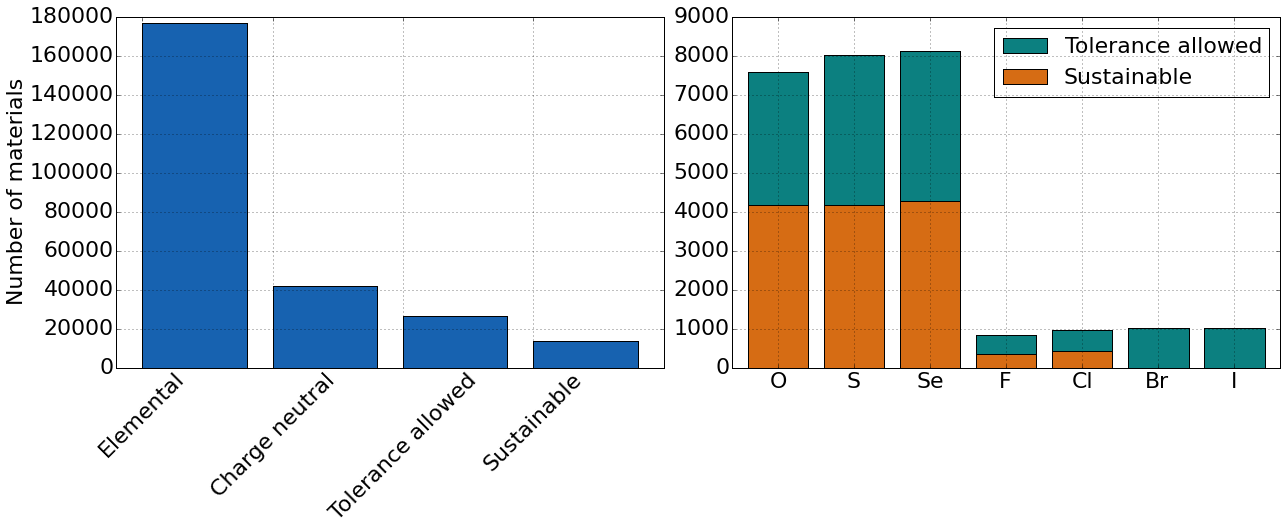

In [17]:
f, ax = plt.subplots(1, 2, sharex=False)
f.set_size_inches(18,7.5)

totals = [initial_total,len(charge_balanced),number_of_perovskites,enviro_perovskites]
labels = ['Elemental','Charge neutral','Tolerance allowed','Sustainable']
ind = np.arange(4)
ax[0].bar(ind,totals,color='#1762B0')
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_xlim(-0.2, 4)
ax[0].grid(True)
ax[0].set_ylabel('Number of materials',fontsize=22)

tots = []
for i in np.arange(7):
    tots.append(anion_stats[i][2]+anion_stats[i][1])

enviros = (anion_stats[0][3],anion_stats[1][3],anion_stats[2][3],anion_stats[3][3],anion_stats[4][3],anion_stats[5][3],anion_stats[6][3])
ind = np.arange(7)
p1 = ax[1].bar(ind,tots,color='#0C8080')
p2 = ax[1].bar(ind,enviros,color='#D66C14')
ax[1].set_xticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4])
ax[1].set_xticklabels(['O', 'S', 'Se', 'F', 'Cl','Br','I'],fontsize=22)
ax[1].legend((p1[0],p2[0]),('Tolerance allowed','Sustainable'),fontsize=22)
ax[1].set_xlim(-0.2, 7)
ax[1].grid(True)
plt.tight_layout()
plt.savefig('BarCharts.png')

In [24]:
for i, e in enumerate(enviros):
    print float(e) / tots[i] * 100

54.9091866281
52.1224947093
52.4646588814
43.0133657351
44.5128205128
0.0
0.0


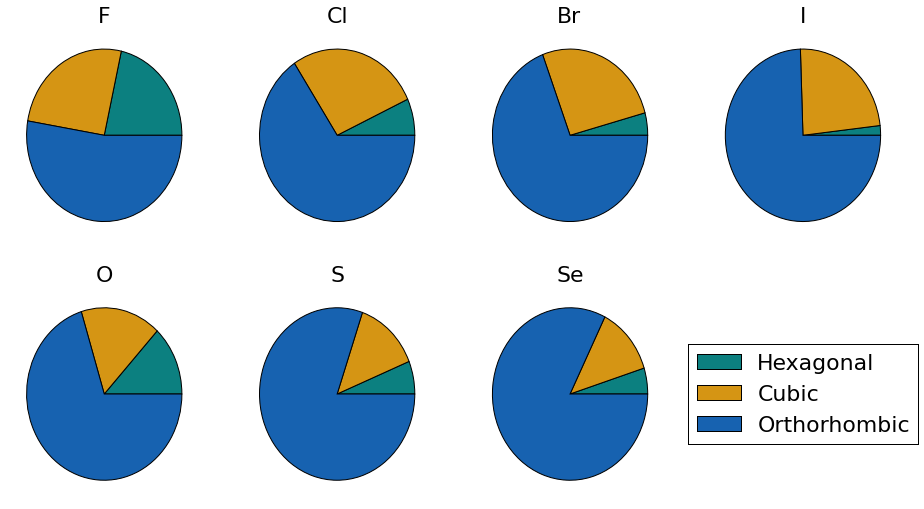

In [19]:
fig, axarr = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(16,8.5)
colours = ['#0C8080','#D59514', '#1762B0']
axarr[0,0].pie([anion_stats[3][0],anion_stats[3][1],anion_stats[3][2]], colors=colours)
axarr[0,1].pie([anion_stats[4][0],anion_stats[4][1],anion_stats[4][2]], colors=colours)
axarr[0,2].pie([anion_stats[5][0],anion_stats[5][1],anion_stats[5][2]], colors=colours)
axarr[0,3].pie([anion_stats[6][0],anion_stats[6][1],anion_stats[6][2]], colors=colours)
axarr[1,0].pie([anion_stats[0][0],anion_stats[0][1],anion_stats[0][2]], colors=colours)
axarr[1,1].pie([anion_stats[1][0],anion_stats[1][1],anion_stats[1][2]], colors=colours)
axarr[1,2].pie([anion_stats[2][0],anion_stats[2][1],anion_stats[2][2]], colors=colours)

axarr[0,0].set_title('F', fontsize=22)
axarr[0,1].set_title('Cl', fontsize=22)
axarr[0,2].set_title('Br', fontsize=22)
axarr[0,3].set_title('I', fontsize=22)
axarr[1,0].set_title('O', fontsize=22)
axarr[1,1].set_title('S', fontsize=22)
axarr[1,2].set_title('Se', fontsize=22)

pie = axarr[1,3].pie([1,2,3],labels=['Hexagonal','Cubic','Orthorhombic'], colors=colours)
axarr[1,3].legend(fontsize=22,loc=10) 
for group in pie:
    for x in group:
        x.set_visible(False)
plt.savefig('Piecharts.png')